In [ ]:
%%shell
rm -rf fdd
git clone https://github.com/Davidvandijcke/fdd.git
pip install geopandas folium matplotlib mapclassify contextily rasterio scikit-image geocube pandas==2.0.0



In [1]:
from FDD import FDD

In [2]:
# load libraries
import geopandas as gpd
import numpy as np
import os
import urllib
import zipfile
import re
#from geocube.api.core import make_geocube
import rasterio as rio
from rasterio.mask import mask
from rasterio.transform import from_origin
from skimage import data, img_as_float, io
from skimage.segmentation import chan_vese
from PIL import Image
import matplotlib.pyplot as plt
from scipy.io import loadmat
from geocube.api.core import make_geocube
import boto3

/var/folders/zs/20zk30ss1dq_90y7_2t9wgvc0000gn/T/ipykernel_87158/3655688178.py:2: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopanda

In [4]:
# # set path
bsdir = "s3://ipsos-dvd/fdd/data/out/ukr/" # set to desired directory
bsdir = "/Users/davidvandijcke/Dropbox (University of Michigan)/rdd/data/out/"

## Now let's segment the map of mobile device activity

In [5]:
grid = gpd.read_file(bsdir + "grid_daily_pings/" + "2022-11-09.geojson")


In [39]:
grid

,date,count,caid,count_ratio,caid_ratio,geometry
0,2022-11-09,0,0,0.0,0.0,"POLYGON ((1019522.90926 5247526.39586, 1020522..."
1,2022-11-09,0,0,0.0,0.0,"POLYGON ((1019522.90926 5368526.39586, 1020522..."
2,2022-11-09,0,0,0.0,0.0,"POLYGON ((1019522.90926 5282526.39586, 1020522..."
3,2022-11-09,0,0,0.0,0.0,"POLYGON ((1019522.90926 5280526.39586, 1020522..."
4,2022-11-09,0,0,0.0,0.0,"POLYGON ((1019522.90926 5356526.39586, 1020522..."
...,...,...,...,...,...,...
1172620,2022-11-09,0,0,0.0,0.0,"POLYGON ((1709294.52614 5524526.39586, 1708522..."
1172621,2022-11-09,0,0,0.0,0.0,"POLYGON ((1709294.52614 5386526.39586, 1708522..."
1172622,2022-11-09,0,0,0.0,0.0,"POLYGON ((1709294.52614 5339526.39586, 1708522..."
1172623,2022-11-09,0,0,0.0,0.0,"POLYGON ((1709294.52614 5463526.39586, 1708522..."


In [48]:
# dissolve to higher granularity
grid['col_label'] = (grid.geometry.centroid.x // 5000).astype(int)
grid['row_label'] = (grid.geometry.centroid.y // 5000).astype(int)
agg_gdf = grid.dissolve(by=['col_label', 'row_label'], aggfunc='sum')


/var/folders/zs/20zk30ss1dq_90y7_2t9wgvc0000gn/T/ipykernel_87158/1061207139.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid['col_label'] = (grid.geometry.centroid.x // 5000).astype(int)
/var/folders/zs/20zk30ss1dq_90y7_2t9wgvc0000gn/T/ipykernel_87158/1061207139.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid['row_label'] = (grid.geometry.centroid.y // 5000).astype(int)
/var/folders/zs/20zk30ss1dq_90y7_2t9wgvc0000gn/T/ipykernel_87158/1061207139.py:5: FutureWarning: The default value of numeric_only in aggfunc='sum' within pandas.DataFrameGroupBy.agg used in dissolve is deprecated. In pandas 2.0, numeric_only will default to False. Either specify numeric_only as additional argument in dissolve

In [49]:
grid

,date,count,caid,count_ratio,caid_ratio,geometry,col_label,row_label,count_jan
0,2022-11-09,0,0,0.0,0.0,"POLYGON ((1019522.90926 5247526.39586, 1020522...",204,1049,NaN
1,2022-11-09,0,0,0.0,0.0,"POLYGON ((1019522.90926 5368526.39586, 1020522...",204,1073,NaN
2,2022-11-09,0,0,0.0,0.0,"POLYGON ((1019522.90926 5282526.39586, 1020522...",204,1056,NaN
3,2022-11-09,0,0,0.0,0.0,"POLYGON ((1019522.90926 5280526.39586, 1020522...",204,1056,NaN
4,2022-11-09,0,0,0.0,0.0,"POLYGON ((1019522.90926 5356526.39586, 1020522...",204,1071,NaN
...,...,...,...,...,...,...,...,...,...
1172620,2022-11-09,0,0,0.0,0.0,"POLYGON ((1709294.52614 5524526.39586, 1708522...",341,1105,NaN
1172621,2022-11-09,0,0,0.0,0.0,"POLYGON ((1709294.52614 5386526.39586, 1708522...",341,1077,NaN
1172622,2022-11-09,0,0,0.0,0.0,"POLYGON ((1709294.52614 5339526.39586, 1708522...",341,1068,NaN
1172623,2022-11-09,0,0,0.0,0.0,"POLYGON ((1709294.52614 5463526.39586, 1708522...",341,1092,NaN


In [46]:
agg_gdf['count_ratio'] = agg_gdf['count'] / agg_gdf['count_jan']

KeyError: 'count_jan'

In [5]:
#grid.explore(column='count_ratio', cmap='Reds', legend=True,  vmax = 0.5)

In [32]:
X1 = np.array(grid.geometry.centroid.x)
X2 = np.array(grid.geometry.centroid.y)
X = np.stack([X1, X2], axis = 1)

Y = np.array(grid['count_ratio'])

# # winsorize
qtile = np.quantile(Y, 0.99)
Y[Y > qtile] = qtile # 0.5

/var/folders/zs/20zk30ss1dq_90y7_2t9wgvc0000gn/T/ipykernel_87158/1331871557.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  X1 = np.array(grid.geometry.centroid.x)
/var/folders/zs/20zk30ss1dq_90y7_2t9wgvc0000gn/T/ipykernel_87158/1331871557.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  X2 = np.array(grid.geometry.centroid.y)


In [33]:
# as image
X1_width = 10000 #np.diff(np.unique(X1)).min()
X2_width = 10000 # np.diff(np.unique(X2)).min()
X = np.stack([X2, X1]).T

In [34]:
# segment
#--------
# parameters
S=16
N = Y.shape[0]
#--------
resolution = 1/int(np.sqrt(N))
model = FDD(Y, X, level = S, lmbda = 5, nu = 0.01, iter = 5000, tol = 5e-5, pick_nu = "MS", CI=False, rectangle=True, resolution=resolution,
            scripted=False)


In [19]:
model.grid_y.shape

(162, 242, 1)

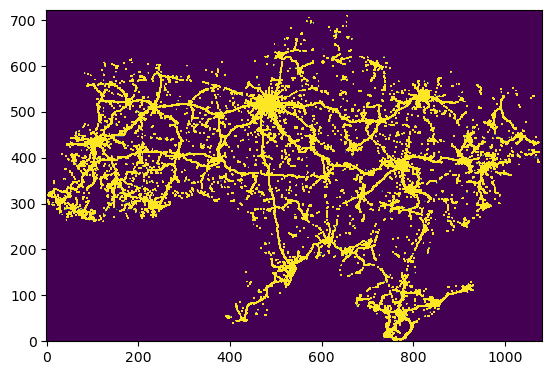

In [37]:
plt.imshow(model.grid_y.squeeze(), origin="lower", vmax=0.0001)

In [10]:
results = model.run()

/home/ubuntu/fdd/src/FDD/primaldual_multi_scaled_tune.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tauu = torch.tensor(  1.0 / torch.sqrt(denom) * res, device=dev)  # torch.tensor(  1.0 / 6.0 * res, device=dev) # *res
/home/ubuntu/fdd/src/FDD/primaldual_multi_scaled_tune.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigmap = torch.tensor( 1.0 / torch.sqrt(denom)  * res, device=dev) # torch.tensor( (1.0 / (3.0 + l))  * res, device=dev) # *res


In [11]:
results['it']

1080

In [12]:
u = results['u']
J_grid = results['J']

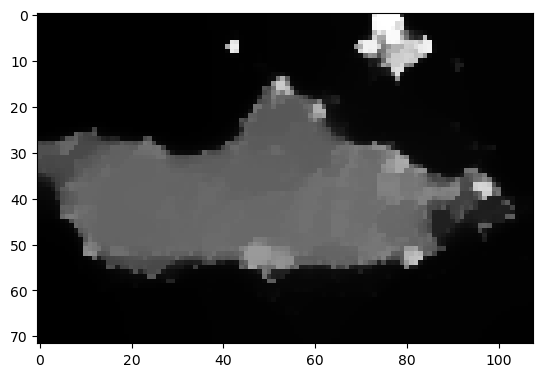

In [27]:
plt.imshow(u, origin ="lower", cmap = "gray")
plt.show()

In [43]:
xmin = np.min(model.X_raw, axis=0)
xmax = np.max(model.X_raw - xmin)
X_coord = model.grid_x * xmax +  np.flip(xmin)

In [44]:
X_coord = X_coord.reshape(-1, X_coord.shape[-1])
Y_coord = u.flatten()

In [55]:
u_gdf = gpd.GeoDataFrame(np.stack([Y_coord, J_grid.flatten()]).T, geometry=gpd.points_from_xy(X_coord[:,0], X_coord[:,1]), crs = grid.crs, columns=['u', 'J_grid'])
u_gdf.loc[u_gdf['J_grid'] == 0, 'J_grid'] = np.nan

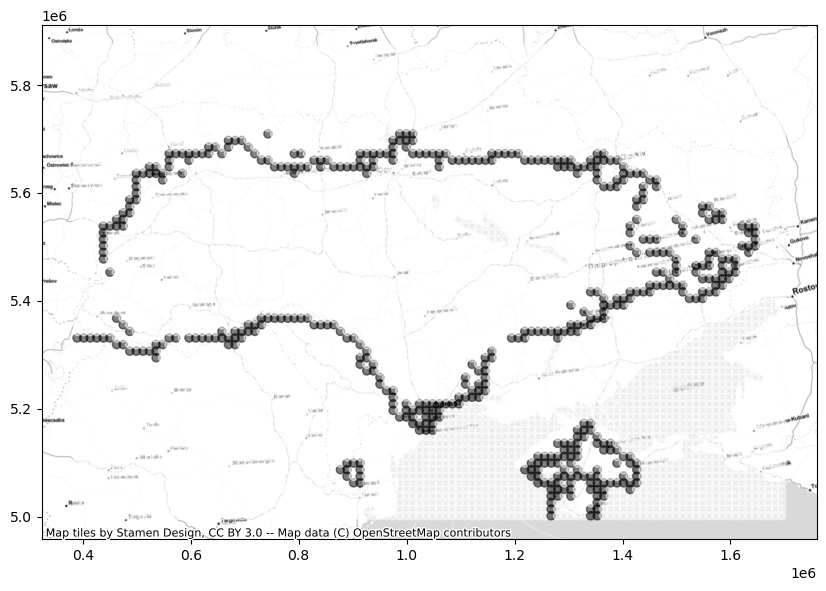

In [49]:
import contextily as ctx
fig, ax =  plt.subplots(figsize=(10,10))
u_gdf.plot(column = "J_grid", cmap = "binary", ax=ax, alpha=0.5)
ctx.add_basemap(ax, crs=u_gdf.crs.to_string(), source=ctx.providers.Stamen.TonerLite)

In [50]:
# merge in ISW shapefile
isw = gpd.read_file("s3://ipsos-dvd/fdd/data/in/ukr/Ukraine_Conflict_Mapping_ARCGIS_Shapefiles/Russian_CoT_in_Ukraine_Shapefiles/UkraineControlMapAO11NOV2022.shp.zip")
isw = isw.to_crs(grid.crs)

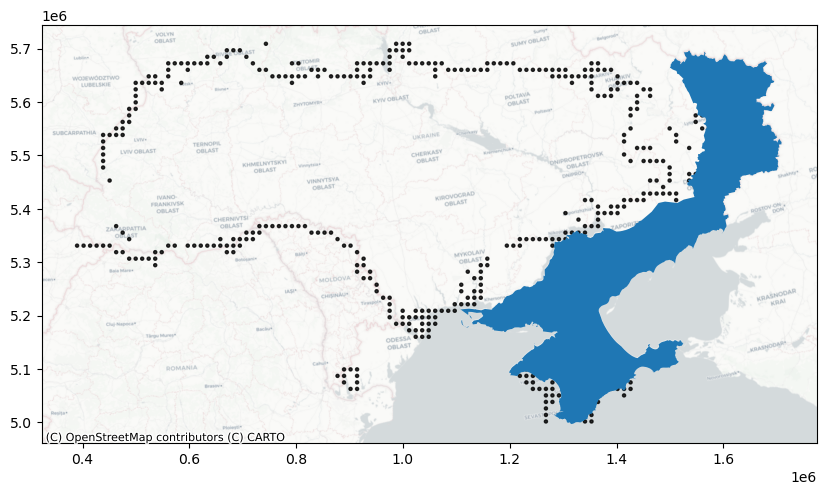

In [76]:
fig, ax = plt.subplots(figsize=(10, 6))
u_gdf.plot(ax=ax, cmap = "binary_r", column="J_grid", alpha=0.8, s=5)
isw.plot(ax=ax)
ctx.add_basemap(ax, crs=u_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)
file_name = "isw_frontline.png"
fn = "/home/ubuntu/results/" + file_name
plt.savefig(fn)
s3 = boto3.client('s3')
with open(fn, "rb") as f:
    s3.upload_fileobj(f, "ipsos-dvd", "fdd/results/figs/" + file_name)


In [72]:
os.getcwd()

'/home/ubuntu/fdd/src/analysis'

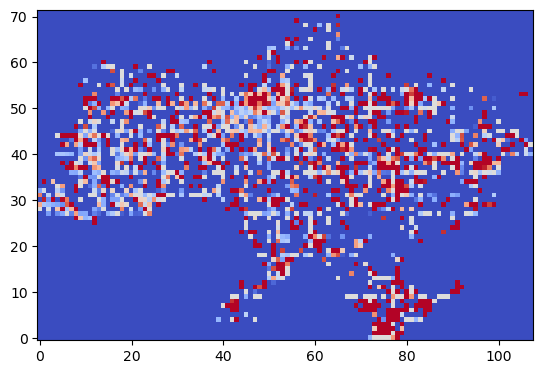

In [265]:
plt.imshow(model.grid_y, origin="lower", cmap="coolwarm")

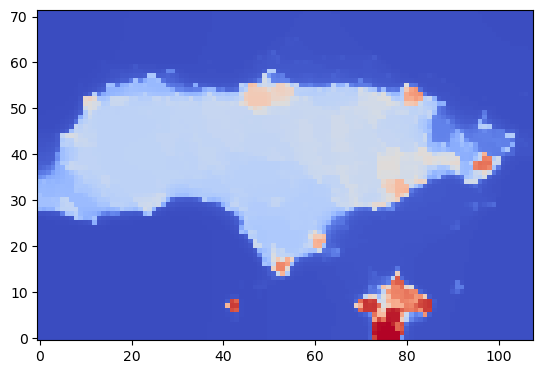

In [266]:
plt.imshow(u, origin="lower", cmap="coolwarm")

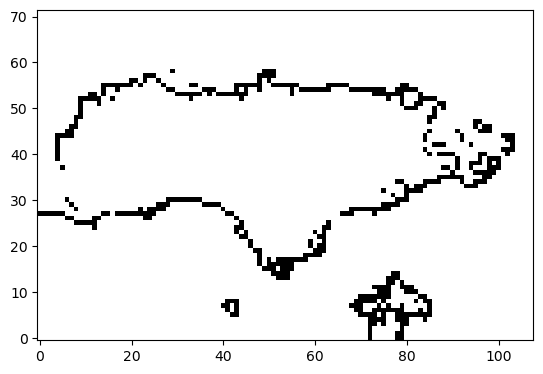

In [267]:
plt.imshow(J_grid, origin="lower", cmap="binary")

In [64]:
import calendar

def generate_date_dict(year=2022, month=11):
    # Get the number of days in the specified month and year
    num_days = calendar.monthrange(year, month)[1]
    
    date_dict = {}

    # Loop through all days in the month
    for day in range(1, num_days+1):
        key_format = f"{year}-{month:02}-{day:02}"
        value_format = f"{day:02}{calendar.month_abbr[month].upper()}{year}"
        date_dict[key_format] = value_format

    return date_dict

# Test
print(generate_date_dict())


{'2022-11-01': '01NOV2022', '2022-11-02': '02NOV2022', '2022-11-03': '03NOV2022', '2022-11-04': '04NOV2022', '2022-11-05': '05NOV2022', '2022-11-06': '06NOV2022', '2022-11-07': '07NOV2022', '2022-11-08': '08NOV2022', '2022-11-09': '09NOV2022', '2022-11-10': '10NOV2022', '2022-11-11': '11NOV2022', '2022-11-12': '12NOV2022', '2022-11-13': '13NOV2022', '2022-11-14': '14NOV2022', '2022-11-15': '15NOV2022', '2022-11-16': '16NOV2022', '2022-11-17': '17NOV2022', '2022-11-18': '18NOV2022', '2022-11-19': '19NOV2022', '2022-11-20': '20NOV2022', '2022-11-21': '21NOV2022', '2022-11-22': '22NOV2022', '2022-11-23': '23NOV2022', '2022-11-24': '24NOV2022', '2022-11-25': '25NOV2022', '2022-11-26': '26NOV2022', '2022-11-27': '27NOV2022', '2022-11-28': '28NOV2022', '2022-11-29': '29NOV2022', '2022-11-30': '30NOV2022'}


In [65]:
date_dict = generate_date_dict()


KeyError: 0

In [86]:
def plotFrontLineISW(key, value, lmbda = 5, nu = 0.01):
        # merge in ISW shapefile
    isw = gpd.read_file("s3://ipsos-dvd/fdd/data/in/ukr/Ukraine_Conflict_Mapping_ARCGIS_Shapefiles/Russian_CoT_in_Ukraine_Shapefiles/UkraineControlMapAO" + value + ".zip")
    isw = isw.to_crs(grid.crs)
    
    print("ISW exists")
    
    grid = gpd.read_file(bsdir + "grid_daily/" + key + ".geojson")
    
    X1 = np.array(grid.geometry.centroid.x)
    X2 = np.array(grid.geometry.centroid.y)
    X = np.stack([X1, X2], axis = 1)

    Y = np.array(grid['count_ratio'])

    # winsorize
    qtile = np.quantile(Y, 0.9)
    Y[Y > qtile] = qtile # 0.5
    
    X = np.stack([X2, X1]).T
    
    # segment
    #--------
    # parameters
    S=16
    N = Y.shape[0]
    #--------
    resolution = 1/int(np.sqrt(N))
    model = FDD(Y, X, level = S, lmbda = lmbda, nu = nu, iter = 10000, tol = 5e-5, pick_nu = "MS", CI=False, rectangle=True, resolution=resolution,
                scripted=False)
    
    results = model.run()
    u = results['u']
    J_grid = results['J']
    
    xmin = np.min(model.X_raw, axis=0)
    xmax = np.max(model.X_raw - xmin)
    X_coord = model.grid_x * xmax +  np.flip(xmin)
    
    X_coord = X_coord.reshape(-1, X_coord.shape[-1])
    Y_coord = u.flatten()
    
    u_gdf = gpd.GeoDataFrame(np.stack([Y_coord, J_grid.flatten()]).T, geometry=gpd.points_from_xy(X_coord[:,0], X_coord[:,1]), crs = grid.crs, columns=['u', 'J_grid'])
    u_gdf.loc[u_gdf['J_grid'] == 0, 'J_grid'] = np.nan  
    
    
    
    fig, ax = plt.subplots(figsize=(10, 6))
    u_gdf.plot(ax=ax, cmap = "binary_r", column="J_grid", alpha=0.8, s=5)
    isw.plot(ax=ax)
    ctx.add_basemap(ax, crs=u_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

In [88]:
key = "2022-11-11"
value = date_dict[key]
plotFrontLineISW(key, value, lmbda=10, nu=0.01)

DriverError: '/vsizip/vsis3/ipsos-dvd/fdd/data/in/ukr/Ukraine_Conflict_Mapping_ARCGIS_Shapefiles/Russian_CoT_in_Ukraine_Shapefiles/UkraineControlMapAO11NOV2022.zip' does not exist in the file system, and is not recognized as a supported dataset name.

In [ ]:
## plot segmentation against ISW in loop
for key, value in date_dict.items():
    try:
        print(key, value)
        plotFrontLineISW(key, value)

        file_name = "isw_frontline_" + key + ".png"
        fn = "/home/ubuntu/results/" + file_name
        plt.savefig(fn)
        s3 = boto3.client('s3')
        with open(fn, "rb") as f:
            s3.upload_fileobj(f, "ipsos-dvd", "fdd/results/figs/" + file_name)
    
    except:
        pass
    

#grid = gpd.read_file(bsdir + "grid_daily/" + "2022-11-11.geojson")


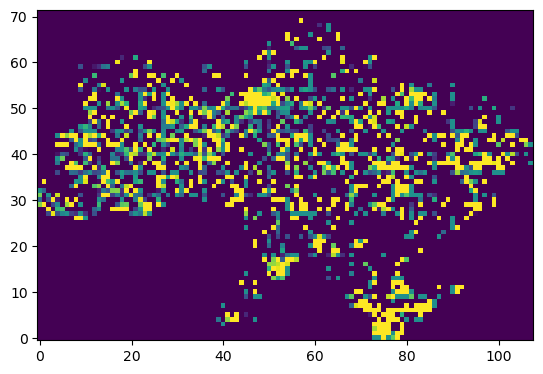

In [82]:
plt.imshow(model.grid_y, origin="lower")

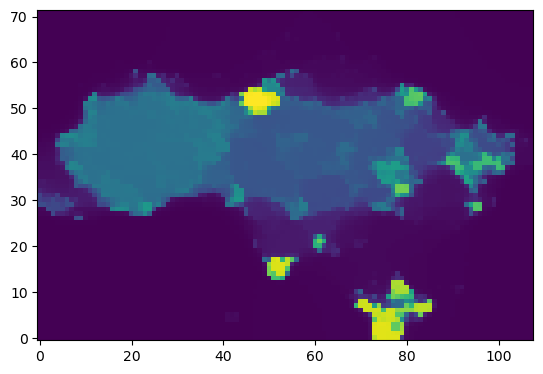

In [83]:
plt.imshow(u, origin="lower")

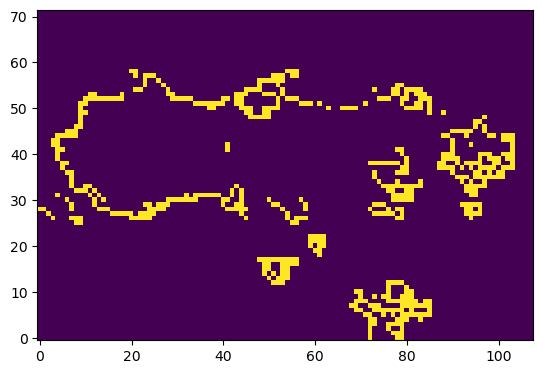

In [84]:
plt.imshow(J_grid, origin="lower")